<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM encoder-decoder

### 1 - Datos
El objecto es utilizar una serie de sucuencias númericas (datos sintéticos) para poner a prueba el uso de las redes LSTM. Este ejemplo se inspiró en otro artículo, lo tienen como referencia en el siguiente link:\
[LINK](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras-part-2/)

In [1]:
# Usar cuando TF migre a una version >= 2.9
# import re

# import numpy as np
# import pandas as pd

# import tensorflow as tf
# from keras.preprocessing.text import one_hot
# from tensorflow.keras.utils import pad_sequences
# from keras.models import Sequential
# from keras.layers.core import Activation, Dropout, Dense
# from keras.layers import Flatten, LSTM, SimpleRNN
# from keras.models import Model
# from tensorflow.keras.layers import Embedding
# from sklearn.model_selection import train_test_split
# from keras.preprocessing.text import Tokenizer
# from keras.layers import Input

In [2]:
import re

import numpy as np
import pandas as pd

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [3]:
# Generar datos sintéticos
X = list()
y = list()

# En ambos casos "X" e "y" son vectores de números de 5 en 5
X = [x for x in range(5, 301, 5)]
y = [x+15 for x in X]

print(f"datos X (len={len(X)}):", X)
print(f"datos y (len={len(y)}):", y)

datos X (len=60): [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300]
datos y (len=60): [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315]


In [4]:
# Se desea agrupar los datos de a 3 elementos
X = np.array(X).reshape(len(X)//3, 3, 1)
y = np.array(y).reshape(len(y)//3, 3, 1)
print("datos X[0:2]:", X[0:2])
print("datos y[0:2]:", y[0:2])

datos X[0:2]: [[[ 5]
  [10]
  [15]]

 [[20]
  [25]
  [30]]]
datos y[0:2]: [[[20]
  [25]
  [30]]

 [[35]
  [40]
  [45]]]


In [5]:
# Verificamos que la secuencia enetrada es igual a la secuencia de salida
# en cuanto a dimensiones
# Tendremos:
#  --> veinte grupos de datos (rows) (20)
#  --> cada grupo compuesto por tres elementos (3)
#  --> cada elemento representado en una sola dimension (1)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (20, 3, 1)
y shape: (20, 3, 1)


### 2 - Preprocesamiento

In [6]:
from sklearn import preprocessing
# Armar el "courpus" de números
data = np.append(X, y)

# Identificar el vocabualario del corpus (todos los números únicos)
labels = list(np.unique(data))

# Al vocabulario (labels) agregarle el token de inicio de secuencia
# Se utiliza el número "0" para el <sos>, aprovechando que el "0"
# no se encuentra en el vocabulario
labels = [0] + labels # <sos> + vocabulario

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(labels)
label_encoder.classes_

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315])

In [7]:
from keras.utils.np_utils import to_categorical

# Preparar datos para consumir por la layers LSTM
# Por cada dato de X e Y se genera su contraparte oneHotEncoding
# X1 equivale a X, es la secuencia de entrada
# X2 equivale a y sin el ultimo elemento, equivale a la secuenca "estado anterior"
# target equivale a Y como OneHotEncoding, la prediccion completa con el ultimo elemento

def get_dataset(X, Y, label_encoder):

    cardinality = len(label_encoder.classes_)
    print("Number of features/cardinality:", cardinality)

    X1, X2, target = list(), list(), list()
    for x, y in zip(X, Y):
        input = list(label_encoder.transform(x.reshape(-1)))
        output = list(label_encoder.transform(y.reshape(-1)))
        # Crear la entrada del "ultimo estado" de salida
        # que es la salida sin el ultimo elemento, que es el que el modelo
        # debe predecir
        output_in = [0] + output[:-1]

        # transformar
        input_encoded = to_categorical(input, num_classes=cardinality)
        output_encoded = to_categorical(output, num_classes=cardinality)
        output_in_encoded = to_categorical(output_in, num_classes=cardinality)
        
        # almacenar
        X1.append(input_encoded)
        X2.append(output_in_encoded)
        target.append(output_encoded)
    return np.array(X1), np.array(X2), np.array(target)

In [8]:
X1, X2, target = get_dataset(X, y, label_encoder)

Number of features/cardinality: 64


El oneHotEncoding tiene una diemsión de -> vocabulario + tokens_especialiciales:
- 63 números únicos (vocab)
- 1 token especial (sos como id=0)

In [9]:
# El vector de salida tiene 3 dimensiones:
# primera dimension es la cantidad de "rows" del dataset
# segunda dimension es el tamaño de la sequencia de entrada/salida
# tercera dimensión es la dimensionalidad del vector oneHotEncoding (cardinality)

print("X1 shape:", X1.shape)
print("X2 shape:", X2.shape)
print("target shape:", target.shape)

in_features = X1.shape[-1]
output_features = target.shape[-1]
print("Number of input_features", in_features)
print("Number of output_features", output_features)

X1 shape: (20, 3, 64)
X2 shape: (20, 3, 64)
target shape: (20, 3, 64)
Number of input_features 64
Number of output_features 64


### 3 - Entrenar el modelo

In [10]:
# El código a continuación se puede utilizar para cualquier encoder-decoder
# que se desee construir con LSTM en el futuro
# y es posiblñe cambiar la layer LSTM por otra (CNN, Attention, etc)
# Fuente:
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/

from keras.models import Model
from keras.layers import Input, LSTM, Dense

# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
    '''
    Args:
        n_input: The cardinality of the input sequence, e.g. number of features, words, or characters for each time step.
        n_output: The cardinality of the output sequence, e.g. number of features, words, or characters for each time step.
        n_units: The number of cells to create in the encoder and decoder models, e.g. 128 or 256.
    output:
        train: Model that can be trained given source, target, and shifted target sequences.
        inference_encoder: Encoder model used when making a prediction for a new source sequence.
        inference_decoder Decoder model use when making a prediction for a new source sequence.
    '''
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]

    # define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)

    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    # return all models
    return model, encoder_model, decoder_model

In [11]:
model, encoder_model, decoder_model = define_models(in_features, output_features, n_units=128)

model.compile(loss='mse', optimizer="Adam")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 64)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 64)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        98816       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

Conclusiones hasta ahora sobre el modelo:
- Nunca se especificó en la layer de entrada cuantos elementos recibirá el sistema, es por eso que el modelo se creó para aceptar una cantidad dinámica de batch y size de elementos de 64 dimensiones --> None, None, 64
- El primer None corresponde al batch dinámico
- El segundo None corresponde al la cantidad de elementos dinámico

¿Cómo sabe cuantos elementos deberá esperar el sistema?
- En este caso siempre entregaremos 3 elementos al encoder y esperaremos 3 elementos del dencoder.
- En un siguiente ejemplo de seq2seq utilizaremos tokens especiales para ello.

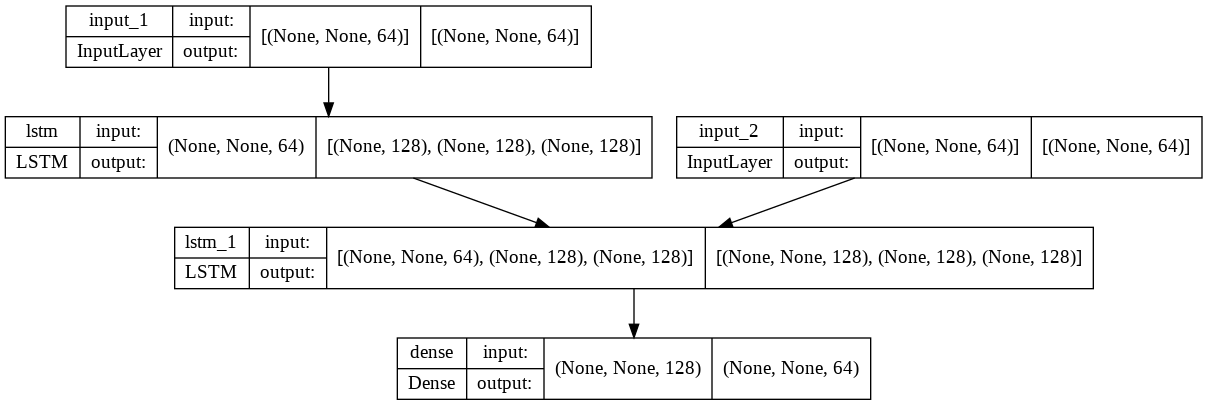

In [12]:
# Modelo completo (encoder+decoder) para poder entrenar
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

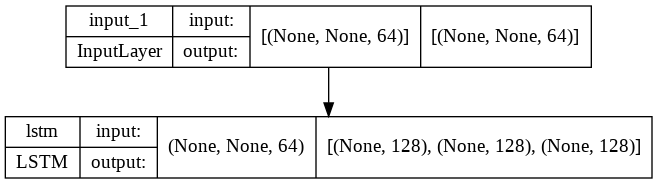

In [13]:
# Modelo solo encoder
from keras.utils.vis_utils import plot_model
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

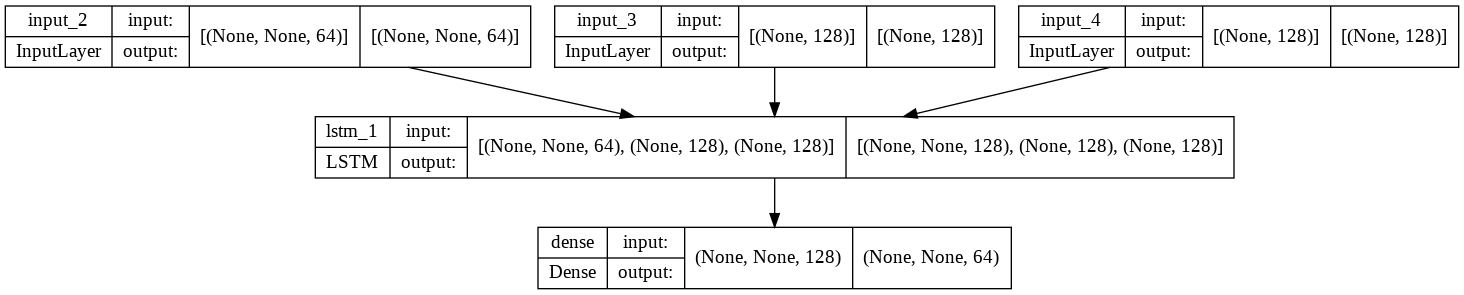

In [14]:
# Modelo solo decoder (para realizar inferencia)
from keras.utils.vis_utils import plot_model
plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
hist = model.fit([X1, X2], target, epochs=150, validation_split=0.2, batch_size=5)

Epoch 1/150
4/4 [==============================] - 4s 278ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3/150
4/4 [==============================] - 0s 13ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 4/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 5/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 7/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 8/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 9/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 10/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0153 - val_loss: 0.0154
Epoch 11/150
4/4 [

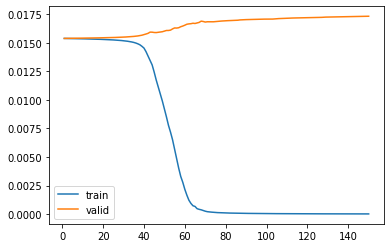

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

In [17]:
def one_hot_decode(encoded_seq, label_encoder):
    idx = [np.argmax(vector) for vector in encoded_seq]
    return label_encoder.inverse_transform(idx)

In [18]:
# Ensayo
x_test = [20, 25, 30]
y_test = [x+15 for x in x_test]

print("y_test:", y_test)

# Transformar los datos a oneHotEncoding
X1_test, X2_test, target_test = get_dataset(np.array([x_test]), np.array([y_test]), label_encoder)

print("X1_test shape:", X1_test.shape)
print("X2_test shape:", X2_test.shape)
print("target_test shape:", target_test.shape)

y_test: [35, 40, 45]
Number of features/cardinality: 64
X1_test shape: (1, 3, 64)
X2_test shape: (1, 3, 64)
target_test shape: (1, 3, 64)


In [19]:
# Cuando quiera por ejemplo recuperar target_test a y_test utilizo:
one_hot_decode(target_test[0], label_encoder)

array([35, 40, 45])

In [20]:
cardinality = len(label_encoder.classes_)

# encode
# Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
# para enviar la primera vez al decoder
state = encoder_model.predict(X1_test)
# start of sequence input --> la primera secuencia de salida-entrada (output_in)
# comienza con el ID cero (el ID seleccionado para <sos>)
output_in = to_categorical(0, num_classes=cardinality)
target_seq = np.array(output_in).reshape(1, 1, cardinality)
print("target_seq shape:", target_seq.shape)

# Vector de predicción
output = list()

for t in range(3):
    # Predicción del próximo elemento
    print("Que recibe como elemlento anterior:", one_hot_decode(target_seq[0], label_encoder))
    y_hat, h, c = decoder_model.predict([target_seq] + state)
    
    # Almacenar la predicción
    output.append(y_hat[0])
    print("Que saca como elemlento nuevo o prediccion:", one_hot_decode(y_hat[0], label_encoder))
    # Actualizar los estados dado la ultimo prediccion
    state = [h, c]
    
    # Actualizar secuencia de entrada con la salida (re-alimentacion)
    target_seq = y_hat

print("y_test:", y_test)
print("y_hat:", one_hot_decode(output, label_encoder))

target_seq shape: (1, 1, 64)
Que recibe como elemlento anterior: [0]
Que saca como elemlento nuevo o prediccion: [35]
Que recibe como elemlento anterior: [35]
Que saca como elemlento nuevo o prediccion: [40]
Que recibe como elemlento anterior: [40]
Que saca como elemlento nuevo o prediccion: [45]
y_test: [35, 40, 45]
y_hat: [35 40 45]


In [21]:
# Podría si quisiera usar el "evaluate" de Keras pero ahí si necesitaré
# de X2:
model.evaluate([X1_test, X2_test], [target_test])

1/1 [==============================] - 3s 3s/step - loss: 1.7511e-05


1.7511158148408867e-05

### 4 - Conclusión
A primera vista parece muy compleja la estructura del encoder-decoder, pero funciona igual en cualquier disciplina de deeplearning:
- En visión para transferencia de estilo, generación de imagenes, etc.
- En NLP desde LSTM hasta Attention y transformes

Hay que pensar el encoder como el generador del "espacio latente". Luego el decoder necesita el espacio latente que representa a la setencia de entrada, la realimentación de los valores de salida del decoder y los estados internos de la LSTM para pasar a la siguiente inferencia hasta concluir la secuencia de salida.